## Imports and paths

In [32]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# import pyogg
import librosa

from tqdm import tqdm # loading bar

from IPython.display import Audio

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier


In [3]:
submission = False

In [4]:
# Check if running on Kaggle
kaggle = ('KAGGLE_KERNEL_RUN_TYPE' in os.environ)
if kaggle:
    # Code specific to Kaggle
    print("Running on Kaggle!")
else:
    print("Not running on Kaggle.")

Running on Kaggle!


In [5]:
if kaggle:
    DATA_DIR = '../input/birdclef-2024/'
else:
    DATA_DIR = "../../data/raw" # local work
    
TRAIN_AUDIO_DIR = os.path.join(DATA_DIR, "train_audio/")

if submission:
    TEST_AUDIO_DIR = os.path.join(DATA_DIR,"test_soundscapes/")
    
else:
    TEST_AUDIO_DIR = os.path.join(DATA_DIR,"unlabeled_soundscapes/")

train_csv_path = os.path.join(DATA_DIR, "train_metadata.csv")

# Exploratory Data Analysis

In [6]:
train_df = pd.read_csv(train_csv_path)
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg


In [7]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24459 entries, 0 to 24458
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   primary_label     24459 non-null  object 
 1   secondary_labels  24459 non-null  object 
 2   type              24459 non-null  object 
 3   latitude          24081 non-null  float64
 4   longitude         24081 non-null  float64
 5   scientific_name   24459 non-null  object 
 6   common_name       24459 non-null  object 
 7   author            24459 non-null  object 
 8   license           24459 non-null  object 
 9   rating            24459 non-null  float64
 10  url               24459 non-null  object 
 11  filename          24459 non-null  object 
dtypes: float64(3), object(9)
memory usage: 2.2+ MB


In [8]:
train_df.isnull().sum()

primary_label         0
secondary_labels      0
type                  0
latitude            378
longitude           378
scientific_name       0
common_name           0
author                0
license               0
rating                0
url                   0
filename              0
dtype: int64

In [9]:
train_df.primary_label.nunique()

182

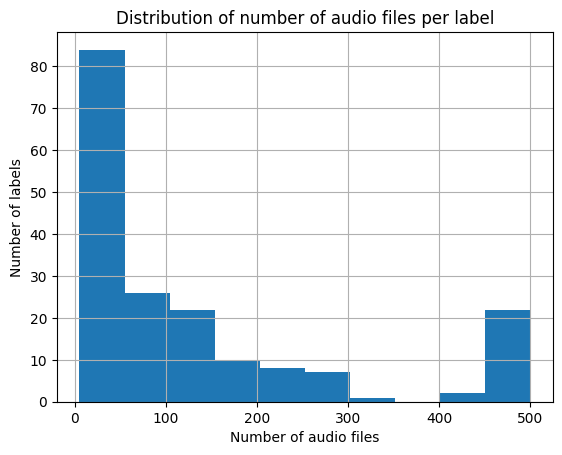

In [10]:
train_df.primary_label.value_counts().hist()
plt.title("Distribution of number of audio files per label")
plt.xlabel("Number of audio files")
plt.ylabel("Number of labels");

In [11]:
train_df.secondary_labels.value_counts()

secondary_labels
[]                                  22567
['houspa']                            186
['eucdov']                             82
['houcro1']                            76
['spodov']                             47
                                    ...  
['blhori1', 'whcbar1']                  1
['grecou1', 'putbab1']                  1
['bkwsti', 'whiter2']                   1
['gargan']                              1
['blrwar1', 'comtai1', 'rorpar']        1
Name: count, Length: 491, dtype: int64

### Audio file import

In [12]:
train_df['filepath'] = train_df.apply(lambda row: os.path.join(TRAIN_AUDIO_DIR, row['filename']), axis=1)
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,../input/birdclef-2024/train_audio/asbfly/XC13...
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,../input/birdclef-2024/train_audio/asbfly/XC16...
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,../input/birdclef-2024/train_audio/asbfly/XC17...
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,../input/birdclef-2024/train_audio/asbfly/XC20...
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,../input/birdclef-2024/train_audio/asbfly/XC20...


In [13]:
audio1 = train_df.filepath.iloc[0]
audio_data, sample_rate = librosa.load(audio1)

In [14]:
audio_data

array([ 1.1239055e-06, -3.5725856e-07, -2.4089284e-06, ...,
        4.8919164e-06, -3.7033487e-07,  0.0000000e+00], dtype=float32)

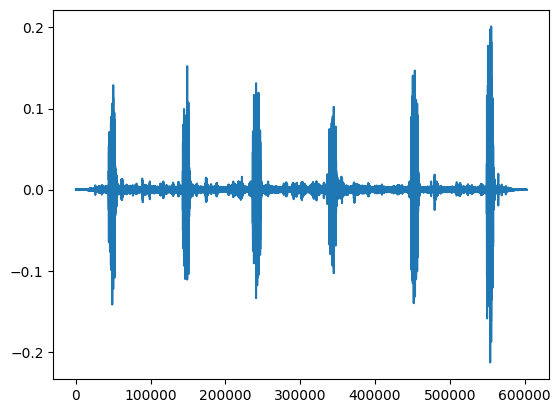

In [15]:
plt.plot(audio_data);

In [16]:
duration = librosa.get_duration(y=audio_data, sr=sample_rate)
duration

27.350249433106576

In [ ]:
Audio(data=audio_data, rate=sample_rate)

###  Filter out large files (for the moment)

In [18]:
train_df['filesize'] = train_df.apply(lambda row: os.path.getsize(row['filepath']), axis=1)
train_df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,filesize
0,asbfly,[],['call'],39.2297,118.1987,Muscicapa dauurica,Asian Brown Flycatcher,Matt Slaymaker,Creative Commons Attribution-NonCommercial-Sha...,5.0,https://www.xeno-canto.org/134896,asbfly/XC134896.ogg,../input/birdclef-2024/train_audio/asbfly/XC13...,196771
1,asbfly,[],['song'],51.4030,104.6401,Muscicapa dauurica,Asian Brown Flycatcher,Magnus Hellström,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/164848,asbfly/XC164848.ogg,../input/birdclef-2024/train_audio/asbfly/XC16...,125336
2,asbfly,[],['song'],36.3319,127.3555,Muscicapa dauurica,Asian Brown Flycatcher,Stuart Fisher,Creative Commons Attribution-NonCommercial-Sha...,2.5,https://www.xeno-canto.org/175797,asbfly/XC175797.ogg,../input/birdclef-2024/train_audio/asbfly/XC17...,206323
3,asbfly,[],['call'],21.1697,70.6005,Muscicapa dauurica,Asian Brown Flycatcher,vir joshi,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/207738,asbfly/XC207738.ogg,../input/birdclef-2024/train_audio/asbfly/XC20...,110256
4,asbfly,[],['call'],15.5442,73.7733,Muscicapa dauurica,Asian Brown Flycatcher,Albert Lastukhin & Sergei Karpeev,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/209218,asbfly/XC209218.ogg,../input/birdclef-2024/train_audio/asbfly/XC20...,376492


In [19]:
train_df.filesize.describe()

count    2.445900e+04
mean     3.194286e+05
std      7.927288e+05
min      7.235000e+03
25%      8.839900e+04
50%      1.722410e+05
75%      3.400315e+05
max      4.670163e+07
Name: filesize, dtype: float64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


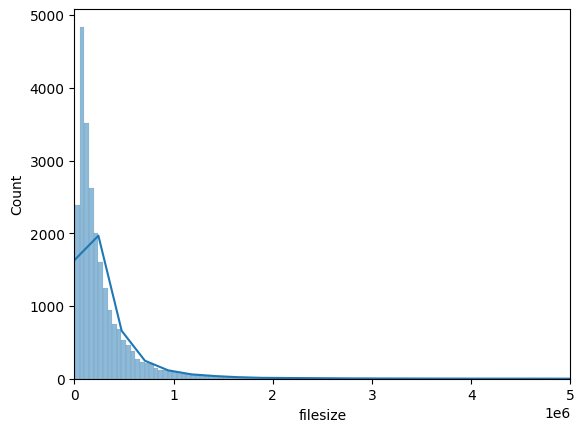

In [20]:
sns.histplot(train_df.filesize, bins=1000, kde=True)
plt.xlim(0, 0.5e7);

In [21]:
train_df = train_df[train_df['filesize'] < 1e6]

## Train test split

In [22]:
random_state = 43

# Define the number of classes to keep
num_classes_to_keep = 100

# Define the fraction of data to keep for classes with more labels
fraction_to_keep = 0.05

# Calculate the minimum number of instances to keep for classes with fewer labels
min_count = 50

# Calculate weights to balance the classes
class_weights = train_df['primary_label'].value_counts()

# Select the top classes to keep based on their frequencies
top_classes = class_weights.head(num_classes_to_keep).index.tolist()

# Initialize an empty DataFrame to store the sampled subset
train_subset_df = pd.DataFrame()

# Iterate over each class
for label, count in class_weights.items():
    # Check if the class is in the top classes to keep
    if label in top_classes:
        # Check if the class has fewer labels than the minimum count
        if count < min_count:
            # Keep all instances for classes with fewer labels
            subset = train_df[train_df['primary_label'] == label]
        else:
            # Randomly sample a fraction for classes with more labels
            fraction = min(fraction_to_keep, min_count / count)  # Adjust fraction if necessary
            subset = train_df[train_df['primary_label'] == label].sample(frac=fraction, random_state=random_state)
        # Append the subset to the final DataFrame
        train_subset_df = pd.concat([train_subset_df, subset])

# Shuffle the final DataFrame to mix the classes
train_subset_df = train_subset_df.sample(frac=1, random_state=random_state).reset_index(drop=True)


In [23]:
train_subset_df.primary_label.value_counts()

primary_label
grejun2    49
grnsan     25
commoo3    25
comsan     25
zitcis1    25
           ..
rossta2     3
whrmun      3
grbeat1     3
pursun3     3
inbrob1     3
Name: count, Length: 100, dtype: int64

In [24]:
# Train val split
train_train_df, val_df = train_test_split(train_subset_df, test_size=0.3, stratify = train_subset_df.primary_label, random_state=random_state) 
X_train_files = train_train_df.filepath
X_val_files = val_df.filepath

y_train = train_train_df.primary_label
y_val = val_df.primary_label


In [25]:
y_train.value_counts()

primary_label
grejun2    34
eaywag1    17
commoo3    17
comsan     17
comgre     17
           ..
whrmun      2
pursun3     2
grbeat1     2
insbab1     2
whcbar1     2
Name: count, Length: 100, dtype: int64

In [26]:
y_val.value_counts()

primary_label
grejun2    15
grnsan      8
commoo3     8
comsan      8
zitcis1     8
           ..
grefla1     1
insbab1     1
litswi1     1
indpit1     1
brcful1     1
Name: count, Length: 100, dtype: int64

In [27]:
# Label encoding
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

# Feature extraction

## Method 1

**MFCC (Mel-Frequency Cepstral Coefficients)**

MFCCs are a feature widely used in audio and speech processing. They represent the short-term power spectrum of a sound. The process to calculate MFCCs involves several steps:

- Frame the Signal: The audio signal is divided into short overlapping frames.
- Apply Windowing: Each frame is windowed, typically with a Hamming window, to minimize spectral leakage.
- Calculate the Discrete Fourier Transform (DFT): The Fast Fourier Transform (FFT) is applied to each windowed frame to convert the audio signal from the time domain to the frequency domain.
- Mel Filtering: Mel filtering is applied to the power spectrum to convert the linear frequency scale to the mel scale, which approximates the human auditory system's response to different frequencies.
- Take the Logarithm: The logarithm of the mel-filterbank energies is taken to mimic the human perception of sound intensity.
- Apply Discrete Cosine Transform (DCT): Finally, the Discrete Cosine Transform is applied to the mel-log spectrum to decorrelate the features and obtain the MFCCs.
- MFCCs capture important spectral characteristics of the audio signal and are commonly used as features for tasks like speech recognition, music genre classification, and audio classification.

**Chroma Features**

Chroma features represent the distribution of energy in different pitch classes (i.e., musical notes) within an audio signal. Chroma features are particularly useful for tasks involving music analysis and classification, such as genre classification, chord recognition, and instrument recognition.

The process to compute chroma features involves the following steps:

- Frame the Signal: Similar to MFCCs, the audio signal is divided into short overlapping frames.
- Apply Windowing: Each frame is windowed.
- Calculate the Short-Time Fourier Transform (STFT): The STFT is applied to each windowed frame to obtain the magnitude spectrum.
- Map Frequencies to Chroma: The frequency spectrum is mapped onto the 12 chroma bands corresponding to the 12 pitch classes (C, C#, D, D#, E, F, F#, G, G#, A, A#, B).
- Sum Across Octaves: Chroma features are usually computed by summing the energy within each chroma band across octaves.

Chroma features are robust to changes in pitch and timbre and are commonly used in music information retrieval tasks.

**Mel Spectrogram**

A Mel spectrogram is a spectrogram where the frequencies are converted to the mel scale, similar to the mel filtering step in MFCC computation. It represents the distribution of energy in different frequency bands over time. Mel spectrograms are often used as features for audio classification tasks.

These features capture different aspects of the audio signal's spectral content and are useful for various audio analysis and classification tasks.

In [104]:
def extract_features1(filepath, mfcc=True, chroma=True, mel=True):
    sample_rate = 32000
    audio_data, _ = librosa.load(filepath, sr=sample_rate)
    
    features = []
    
    if mfcc:
        mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
        features.append(np.mean(mfccs, axis=1))
    
    if chroma:
        chroma = librosa.feature.chroma_stft(y=audio_data, sr=sample_rate)
        features.append(np.mean(chroma, axis=1))
    
    if mel:
        mel = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)
        features.append(np.mean(mel, axis=1))
    
    return np.concatenate(features)


In [105]:
def extract_features_filepaths1(X_files):
    features = []

    # Wrap the loop with tqdm to add a progress bar
    for filepath in tqdm(X_files, desc='Processing files', total=len(X_files)):

        # Extract features
        audio_features = extract_features1(filepath)

        # Append features and label
        features.append(audio_features)

    X = np.array(features)
    
    return X
    

In [106]:
X_train1 = extract_features_filepaths1(X_train_files)

Processing files:   8%|▊         | 62/786 [00:19<03:02,  3.97it/s]/opt/conda/lib/python3.10/site-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(
Processing files:  89%|████████▊ | 696/786 [04:13<00:32,  2.75it/s]


KeyboardInterrupt: 

In [42]:
X_val1 = extract_features_filepaths(X_val_files)

Processing files:   0%|          | 0/338 [00:00<?, ?it/s]

In [ ]:
X_train1.shape

In [ ]:
plt.plot(X_train1.T);

## Method 2: improved feature encoding

In [44]:
def extract_features2(filepath, mfcc=True, chroma=True, mel=True, contrast=True, centroid=True, zero_crossing=True, rms_energy=True, threshold=0.1):
    sample_rate = 32000
    audio_data, _ = librosa.load(filepath, sr=sample_rate)
    
    features = []
    bird_song_segments = []
    
    if rms_energy:
        rms = librosa.feature.rms(y=audio_data)
        rms_mean = np.mean(rms)
        rms_threshold = threshold * rms_mean
        
        # Identify segments where RMS energy exceeds the threshold
        segments = librosa.effects.split(y=audio_data, top_db=rms_threshold)
        
        for segment in segments:
            bird_song_segments.extend(range(segment[0], segment[1] + 1))
    
    if mfcc:
        mfccs = librosa.feature.mfcc(y=audio_data[bird_song_segments], sr=sample_rate, n_mfcc=40)
        features.append(np.mean(mfccs, axis=1))
    
    if chroma:
        chroma = librosa.feature.chroma_stft(y=audio_data[bird_song_segments], sr=sample_rate)
        features.append(np.mean(chroma, axis=1))
    
    if mel:
        mel = librosa.feature.melspectrogram(y=audio_data[bird_song_segments], sr=sample_rate)
        features.append(np.mean(mel, axis=1))
    
    if contrast:
        contrast = librosa.feature.spectral_contrast(y=audio_data[bird_song_segments], sr=sample_rate)
        features.append(np.mean(contrast, axis=1))
    
    if centroid:
        centroid = librosa.feature.spectral_centroid(y=audio_data[bird_song_segments], sr=sample_rate)
        features.append(np.mean(centroid, axis=1))  # Modify this line
    
    if zero_crossing:
        zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio_data[bird_song_segments])
        features.append(np.mean(zero_crossing_rate, axis=1))  # Modify this line
    
    return np.concatenate(features)


In [ ]:
def extract_features_filepaths2(X_files):
    features = []

    # Wrap the loop with tqdm to add a progress bar
    for filepath in tqdm(X_files, desc='Processing files', total=len(X_files)):

        # Extract features
        audio_features = extract_features2(filepath)

        # Append features and label
        features.append(audio_features)

    X = np.array(features)
    
    return X
    

In [46]:
X_train2 = extract_features_filepaths2(X_train_files)

Processing files:   0%|          | 0/786 [00:00<?, ?it/s]

/home/bfrisque/.pyenv/versions/3.10.6/envs/birdclef2024-lewagon-1601/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1025

  warnings.warn(


In [47]:
X_val2 = extract_features_filepaths2(X_val_files)

Processing files:   0%|          | 0/338 [00:00<?, ?it/s]

/home/bfrisque/.pyenv/versions/3.10.6/envs/birdclef2024-lewagon-1601/lib/python3.10/site-packages/librosa/core/spectrum.py:257: UserWarning: n_fft=2048 is too large for input signal of length=1537

  warnings.warn(


## Method 3 : Features for CNN

In [33]:
def extract_features3(filepath, max_length=3000):
    sample_rate = 32000
    audio_data, _ = librosa.load(filepath, sr=sample_rate)
    mfccs = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    
    # Pad or truncate mfccs to ensure a fixed length
    if mfccs.shape[1] < max_length:
        pad_width = max_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    elif mfccs.shape[1] > max_length:
        mfccs = mfccs[:, :max_length]
    
    return mfccs

In [34]:
def extract_features_filepaths3(X_files):
    features = []

    # Wrap the loop with tqdm to add a progress bar
    for filepath in tqdm(X_files, desc='Processing files', total=len(X_files)):

        # Extract features
        audio_features = extract_features3(filepath)

        # Append features and label
        features.append(audio_features)

    X = np.array(features)
    
    return X
    

# Model

## Model 1 : Baseline - RandomForest

In [49]:
# Train a classifier
classifier = RandomForestClassifier(n_estimators=100, random_state=42)
classifier.fit(X_train, y_train_encoded)


RandomForestClassifier(random_state=42)

In [50]:
# Predict
y_pred_encoded = classifier.predict(X_val)

# Evaluate
accuracy = accuracy_score(y_val_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy:.1%}")

Accuracy: 16.3%


## Model 2 : Random forest with feature encoding 2

In [66]:
# Train a classifier
classifier_bis = RandomForestClassifier(n_estimators=500, random_state=42, verbose=1, n_jobs=-1)
classifier_bis.fit(X_train_bis, y_train_encoded)


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.

[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s

[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    0.8s

[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:    1.8s

[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:    2.2s finished


RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42, verbose=1)

In [65]:
# Predict
y_pred_encoded_bis = classifier_bis.predict(X_val_bis)

# Evaluate
accuracy_bis = accuracy_score(y_val_encoded, y_pred_encoded_bis)
print(f"Accuracy: {accuracy_bis:.1%}")

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.

[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s

[Parallel(n_jobs=12)]: Done 176 tasks      | elapsed:    0.1s

[Parallel(n_jobs=12)]: Done 426 tasks      | elapsed:    0.2s


Accuracy: 14.5%


[Parallel(n_jobs=12)]: Done 500 out of 500 | elapsed:    0.2s finished


## Model 3 : Deep learning with CNN

In [35]:
X_train3 = extract_features_filepaths3(X_train_files)

Processing files: 100%|██████████| 786/786 [01:50<00:00,  7.13it/s]


In [36]:
X_val3 = extract_features_filepaths3(X_val_files)

Processing files: 100%|██████████| 338/338 [00:41<00:00,  8.14it/s]


In [45]:
# Adding number of channels (1)
X_train3 = np.expand_dims(X_train3, -1)
X_val3 = np.expand_dims(X_val3, -1)

In [40]:
from tensorflow.keras.utils import to_categorical

y_train_cat = to_categorical(y_train_encoded)
y_val_cat = to_categorical(y_val_encoded)

In [52]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout


# Define CNN architecture
def create_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [53]:
model = create_model(input_shape=X_train3.shape[1:], num_classes=num_classes_to_keep)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 38, 2998, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 19, 1499, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 17, 1497, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 748, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 746, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 373, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 143232)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    36,667,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        25,700 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,851,812 (140.58 MB)

 Trainable params: 36,851,812 (140.58 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

# Now, you can include the early stopping callback in your model.fit() call
history = model.fit(X_train3, y_train_cat, batch_size=32, epochs=100, validation_data=(X_val3, y_val_cat), callbacks=[early_stopping])


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 133ms/step - accuracy: 0.2032 - loss: 4.2459 - val_accuracy: 0.0207 - val_loss: 4.5408
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.3134 - loss: 3.2651 - val_accuracy: 0.0237 - val_loss: 5.4198
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.5586 - loss: 1.8599 - val_accuracy: 0.0118 - val_loss: 6.3145
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.7308 - loss: 1.1077 - val_accuracy: 0.0178 - val_loss: 7.4265
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8120 - loss: 0.7195 - val_accuracy: 0.0237 - val_loss: 8.3838
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.8890 - loss: 0.5041 - val_accuracy: 0.0207 - val_loss: 9.2278
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - accuracy: 0.9156 - loss: 0.4874 - val_accuracy: 0.0355 - val_loss: 8.6276
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - accuracy: 0.9558 - loss: 0.2434 - val_accu

#### Grid search


In [34]:
# Define the parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a random forest classifier
classifier = RandomForestClassifier(random_state=42)

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=classifier, param_grid=param_grid, cv=3, n_jobs=-1)
grid_search.fit(X_train, y_train_encoded)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Train the classifier with the best parameters
best_classifier = RandomForestClassifier(**best_params, random_state=42)
best_classifier.fit(X_train, y_train_encoded)

/home/bfrisque/.pyenv/versions/3.10.6/envs/birdclef2024-lewagon-1601/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.

  warnings.warn(


Best Parameters: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Best Score: 0.1895674300254453


RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

In [241]:
# Define the parameter grid for tuning
param_dist= {
    'n_estimators': stats.randint(250, 400),
    'max_depth': stats.randint(15, 30),
    'min_samples_leaf': [1, 2, 4]
}

# Create a random forest classifier
classifier = RandomForestClassifier(random_state=42)

# Perform grid search cross-validation
random_search = RandomizedSearchCV(estimator=classifier, param_distributions=param_dist, cv=3, n_jobs=-1, verbose=2)
random_search.fit(X_train, y_train_encoded)

# Get the best parameters and the best score
best_params = random_search.best_params_
best_score = random_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/home/bfrisque/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.

  warnings.warn(


Best Parameters: {'max_depth': 23, 'min_samples_leaf': 1, 'n_estimators': 380}

Best Score: 0.18447837150127225


In [35]:
# Train the classifier with the best parameters
best_classifier = RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300, random_state=42)
best_classifier.fit(X_train, y_train_encoded)

RandomForestClassifier(max_depth=20, min_samples_leaf=2, n_estimators=300,
                       random_state=42)

In [36]:
# Predict
y_pred_encoded = best_classifier.predict(X_val)

# # Evaluate
accuracy = accuracy_score(y_val_encoded, y_pred_encoded)
print(f"Accuracy: {accuracy:.1%}")

Accuracy: 18.0%


### XGBoost

In [214]:
xg_train = xgb.DMatrix(X_train, label=y_train_encoded)
xg_val = xgb.DMatrix(X_val, label=y_val_encoded)

# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.1
param['max_depth'] = 10
param['nthread'] = 4
param['num_class'] = y_train.nunique()


# Specify which dataset and which metric should be used for early stopping.
early_stop = xgb.callback.EarlyStopping(rounds=5,
                                        save_best=True,
                                        data_name='validation')

watchlist = [(xg_train, 'train'), (xg_val, 'validation')]

xgb_classifier = xgb.train(param, xg_train, num_boost_round=500, evals=watchlist, callbacks=[early_stop])


[0]	train-mlogloss:4.32857	validation-mlogloss:4.50043

[1]	train-mlogloss:4.07307	validation-mlogloss:4.42600

[2]	train-mlogloss:3.82501	validation-mlogloss:4.36657

[3]	train-mlogloss:3.60440	validation-mlogloss:4.32543

[4]	train-mlogloss:3.38720	validation-mlogloss:4.29525

[5]	train-mlogloss:3.18605	validation-mlogloss:4.26659

[6]	train-mlogloss:3.00088	validation-mlogloss:4.24477

[7]	train-mlogloss:2.82437	validation-mlogloss:4.22647

[8]	train-mlogloss:2.66095	validation-mlogloss:4.21169

[9]	train-mlogloss:2.50404	validation-mlogloss:4.19800

[10]	train-mlogloss:2.36134	validation-mlogloss:4.18865

[11]	train-mlogloss:2.22411	validation-mlogloss:4.18142

[12]	train-mlogloss:2.09624	validation-mlogloss:4.17259

[13]	train-mlogloss:1.97634	validation-mlogloss:4.16442

[14]	train-mlogloss:1.86594	validation-mlogloss:4.15157

[15]	train-mlogloss:1.76169	validation-mlogloss:4.13602

[16]	train-mlogloss:1.66335	validation-mlogloss:4.12949

[17]	train-mlogloss:1.57230	validation-ml

In [215]:
y_val_pred_encoded = xgb_classifier.predict(dval).astype(np.int32)

# Decode the predicted labels
y_val_pred = label_encoder.inverse_transform(y_val_pred_encoded)

# Evaluate
accuracy = accuracy_score(y_val, y_val_pred)
print(f"Accuracy: {accuracy:.1%}")

Accuracy: 13.6%
